# Chorus Example: Running LegNet predictions


## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Sei environment
chorus setup --oracle legnet

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

## Setup and Imports

In [1]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Chorus version: 0.1.0


## 1. Setting up Reference Genome and Sei Oracle

In [2]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

2025-12-09 09:51:05,272 - chorus.utils.annotations - INFO - Annotation file already exists: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf



Setting up gene annotations...
Using annotations: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf


In [3]:
# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Create Enformer oracle with environment isolation
print("\nCreating LegNet oracle...")
# For different configurations:
# - Force CPU: device='cpu'
# - Use specific GPU: device='cuda:0'
oracle = chorus.create_oracle(
    'legnet',
    cell_type="HepG2",
    assay="LentiMPRA",
    use_environment=True,
    reference_fasta=str(genome_path),
    device="cpu:0",
)

# Load pre-trained model
print("\nLoading pre-trained LegNet model...")
print("To force CPU usage: device='cpu'")
print("To disable timeout: export CHORUS_NO_TIMEOUT=1")
oracle.load_pretrained_model(weights="/home/penzard/pinellolab/chorus/chorus/oracles/legnet/")
print("Model loaded successfully!")

2025-12-09 09:51:05,283 - chorus.core.base - INFO - Device set to: cpu:0
2025-12-09 09:51:05,318 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /home/penzard/conda/bin/conda
2025-12-09 09:51:05,319 - chorus.core.environment.manager - INFO - Found mamba at: /home/penzard/conda/bin/mamba


Setting up reference genome...
Using genome: /home/penzard/pinellolab/chorus/genomes/hg38.fa

Creating LegNet oracle...


2025-12-09 09:51:06,504 - chorus.core.base - INFO - Using conda environment: chorus-legnet



Loading pre-trained LegNet model...
To force CPU usage: device='cpu'
To disable timeout: export CHORUS_NO_TIMEOUT=1


2025-12-09 09:51:13,175 - chorus.oracles.legnet - INFO - LegNet model loaded successfully in environment!


Model loaded successfully!


## 2. Exploring Available Tracks

For LegNet model only MPRA assay for cell line you specified is available. 

In [4]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
print(assay_types)
# List available cell types (show first 20 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
print(cell_types)

Available assay types (1):
['LentiMPRA']
Available cell types (1):
['HepG2']


## Example A: Wild-type Sequence Prediction


In [5]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


In [6]:
wt_results = oracle.predict(
    ('chrX', 48726820, 48841508),
)

# Print statistics
for track_id, predictions in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")

2025-12-09 09:52:52,389 - chorus.core.result - WARNING - Unknown implementation 'LentiMPRA'. Available: ATAC, CAGE, CHIP, DNASE, RNA



LentiMPRA:HepG2:
  Shape: (2294,)
  Mean signal: -0.7049
  Max signal: 1.5574


In [7]:
import coolbox
from coolbox.api import *

/tmp/track-eao7z0_h/coolbox.bedgraph


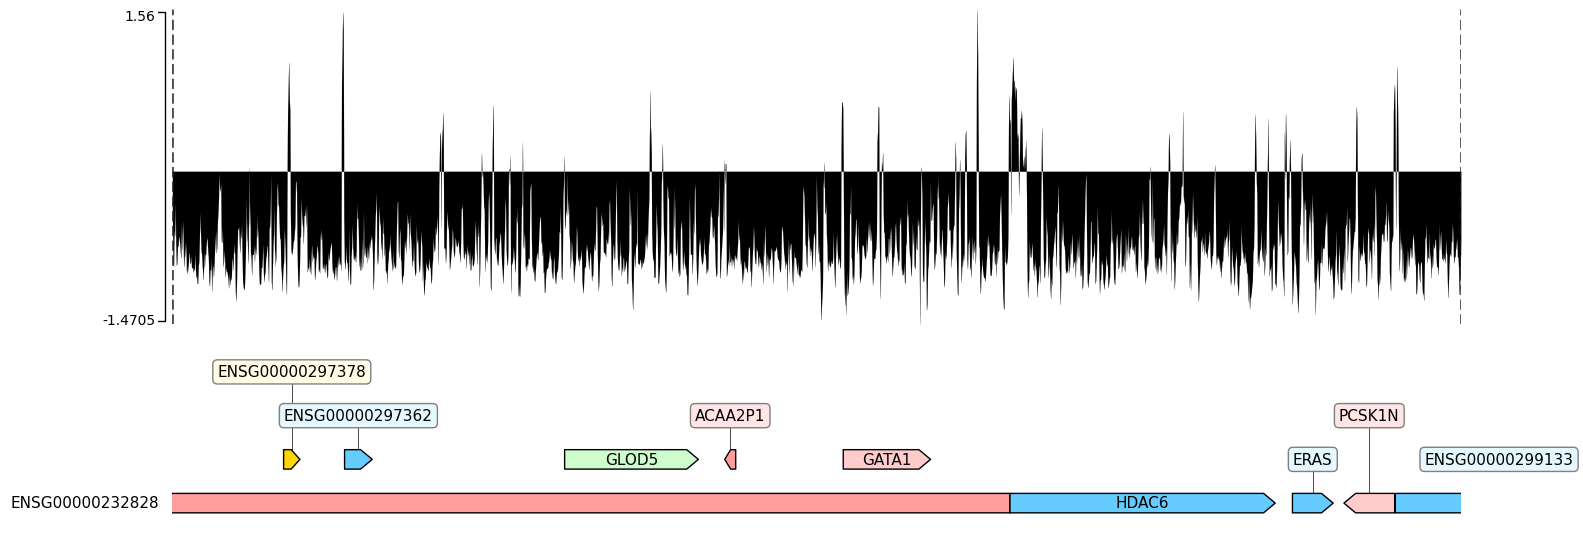

In [11]:
preds = list(wt_results.values())

frame = preds[0].get_coolbox_representation(add_xaxis=False)   +\
        Spacer(0.1) + \
        GTF(str(gtf_path)) + TrackHeight(5)
    
frame.plot('chrX:48726820-48841508') 

By default, LegNet will predict signal in log scale and with sliding step equal to 50. 

When comparing LegNet prediction with DNASE tracks, it might be convenient to perform exponent transformation before comparison

/tmp/track-vw2cxdx6/coolbox.bedgraph


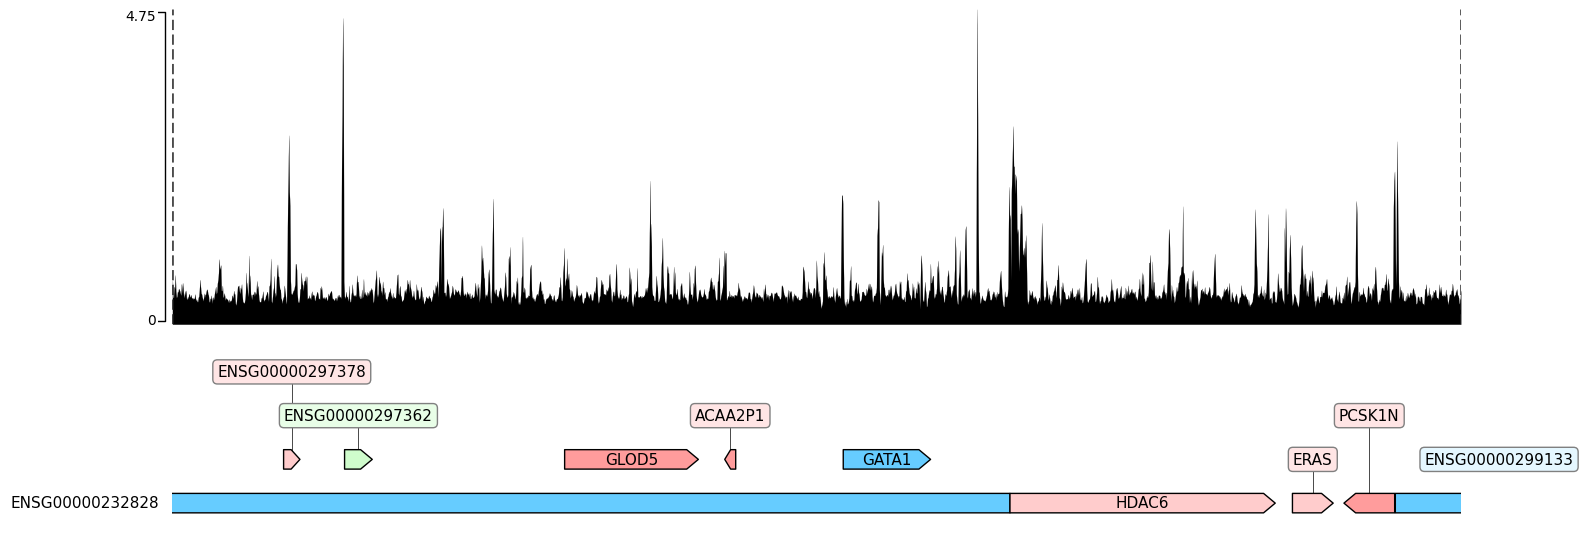

In [12]:
preds = list(wt_results.values())
frame = preds[0].exp().get_coolbox_representation(add_xaxis=False, )   +\
        Spacer(0.1) + \
        GTF(str(gtf_path)) + TrackHeight(5)
    
frame.plot('chrX:48726820-48841508') 